In [1]:
!pip install d2l==0.14

     |████████████████████████████████| 48 kB 4.1 MB/s 


In [2]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
from torch import nn
from d2l import torch as d2l
from tqdm import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data=pd.read_csv('drive/MyDrive/database/california house price/train.csv')
test_data=pd.read_csv('drive/MyDrive/database/california house price/test.csv')

In [5]:
train_data.shape,test_data.shape

((47439, 41), (31626, 40))

删除售价，这是我们要预测的

In [6]:
all_features = pd.concat((train_data.loc[:, train_data.columns != 'Sold Price'], test_data.iloc[:, 1:]))
all_features.info() # info方法可以总览数据

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79065 entries, 0 to 31625
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           47439 non-null  float64
 1   Address                      79065 non-null  object 
 2   Summary                      78226 non-null  object 
 3   Type                         79065 non-null  object 
 4   Year built                   77123 non-null  float64
 5   Heating                      67552 non-null  object 
 6   Cooling                      63956 non-null  object 
 7   Parking                      77389 non-null  object 
 8   Lot                          56076 non-null  float64
 9   Bedrooms                     74467 non-null  object 
 10  Bathrooms                    73655 non-null  float64
 11  Full bathrooms               66137 non-null  float64
 12  Total interior livable area  75187 non-null  float64
 13  Total spaces    

将所有缺失的值替换为相应特征的平均值。通过将特征重新缩放到零均值和单位方差来标准化数据

In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

如果我们直接用老师提供的代码(即上面被注释掉的代码)，那kaggle就会报一个错误：

Your notebook tried to allocate more memory than is available. It has restarted.

这说明特征分布太过分散了，如果用独热编码就会占用大量内存，导致重启

简单起见，接下来我尝试跳过对字符串的处理，只利用数值特征进行训练

In [8]:
all_features = all_features[numeric_features[1:]] # 原本第一列是Id，去掉
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79065 entries, 0 to 31625
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year built                   79065 non-null  float64
 1   Lot                          79065 non-null  float64
 2   Bathrooms                    79065 non-null  float64
 3   Full bathrooms               79065 non-null  float64
 4   Total interior livable area  79065 non-null  float64
 5   Total spaces                 79065 non-null  float64
 6   Garage spaces                79065 non-null  float64
 7   Elementary School Score      79065 non-null  float64
 8   Elementary School Distance   79065 non-null  float64
 9   Middle School Score          79065 non-null  float64
 10  Middle School Distance       79065 non-null  float64
 11  High School Score            79065 non-null  float64
 12  High School Distance         79065 non-null  float64
 13  Tax assessed val

从padnas格式中提取NumPy格式，并将其转换为张量表示

In [9]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
# 注意课上数据的标签列为SalePrice，与比赛用的标签列名不同
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1, 1),
                            dtype=torch.float32)

接下来定义实验的模型

In [10]:
loss=nn.MSELoss()
in_features=train_features.shape[1]
def get_net():
  net=nn.Sequential(nn.Linear(in_features,16),nn.ReLU(),nn.Linear(16,1))
  return net

我们更关心相对误差y-y^/y，解决这个问题的一种方法是用价格预测的对数来衡量差异


In [11]:
def log_rmse(net,features,labels):
  clipped_preds=torch.clamp(net(features),1,float('inf'))
  rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
  return rmse.item()

定义训练函数

In [12]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
  train_ls,test_ls=[],[]
  train_iter=d2l.load_array((train_features,train_labels),batch_size)
  optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)
  for epoch in range(num_epochs):
    for X,y in train_iter:
      optimizer.zero_grad()
      l=loss(net(X),y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net,train_features,train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net,test_features,test_labels))
  return train_ls,test_ls

K折交叉验证

In [13]:
def get_k_fold_data(k,i,X,y):
  assert k>1
  fold_size=X.shape[0]//k
  X_train,y_train=None,None
  for j in range(k):
    idx=slice(j*fold_size,(j+1)*fold_size)
    X_part,y_part=X[idx,:],y[idx]
    if j==i:
      X_valid,y_valid=X_part,y_part
    elif X_train is None:
      X_train,y_train=X_part,y_part
    else:
      X_train=torch.cat([X_train,X_part],0)
      y_train=torch.cat([y_train,y_part],0)
  return X_train,y_train,X_valid,y_valid

返回训练和验证误差的平均值

In [14]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
  train_l_sum,valid_l_sum=0,0
  for i in range(k):
    data=get_k_fold_data(k,i,X_train,y_train)
    net=get_net()
    train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
    train_l_sum+=train_ls[-1]
    valid_l_sum+=valid_ls[-1]
    if i==0:
      d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],legend=['trian','valid'],yscale='log')
    print(f'fold{i+1},train log rmse{float(train_ls[-1]):f}'f' valid log rmse{float(valid_ls[-1]):f}')
  return train_l_sum/k,valid_l_sum/k

开始训练

fold1,train log rmse0.469608 valid log rmse0.454679
fold2,train log rmse0.469358 valid log rmse0.456947
fold3,train log rmse0.484989 valid log rmse0.455436
fold4,train log rmse0.474791 valid log rmse0.453342
fold5,train log rmse0.317918 valid log rmse0.332337
fold6,train log rmse0.455747 valid log rmse0.482917
fold7,train log rmse0.456968 valid log rmse0.519037
7-折验证：平均训练log rmse:0.447054,平均验证log rmse：0.450671


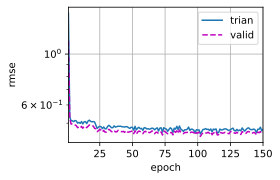

In [18]:
k,num_epochs,lr,weight_decay,batch_size=7,150,0.8,0,128
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)

print(f'{k}-折验证：平均训练log rmse:{float(train_l):f},'f'平均验证log rmse：{float(valid_l):f}')

In [20]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.469789


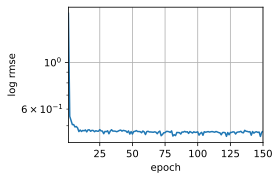

In [21]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)